# Building stock weather aggregation.

In this example, we'll aggregate ERA5 weather data for Finland
based on population density statistics for the purposes
of simple thermal modelling of residential building stock heat demand.
Unlike when calculating PV or wind power production or degree-day heat demand,
we're not interested in the *accumulated* weather, but instead on the *average*
weather over the desired geographical distribution.
For this, we'll exploit the `layout` feature in `atlite`,
except that the "capacity layouts" we'll be using are normalized,
so that they yield weighted average values instead of accumulated ones.

### The weather data parameters we're interested in are:

1. Ambient temperature.
2. Direct solar irradiation for vertical surfaces facing the cardinal directions.
3. Diffuse solar irradiation for vertical surfaces facing the cardinal directions.

This example borrows heavily from the previous examples for
[creating a cutout](https://atlite.readthedocs.io/en/latest/examples/create_cutout.html)
and [historic PV and wind comparison](https://atlite.readthedocs.io/en/latest/examples/historic-comparison-germany.html),
so familiarizing oneself with them might help with following this one.

## Import necessary packages

As usual, we'll need to start by importing the necessary packages.

In [1]:
import logging

import atlite

logging.basicConfig(level=logging.INFO)

## Defining the Finland cutout from ERA5

Here, we'll define the `cutout` serving as the basis for our calculations.
For the purposes of this example, we'll be using ERA5 data for Finland for
the June of 2011.
We'll use a `GeoDataFrame` for determining the bounding box for Finland.
*(And later for clipping the population density data)*

In [2]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
finland = world.loc[world.iso_a3 == "FIN"]
x1, y1, x2, y2 = finland.bounds.values[0]
cutout = atlite.Cutout(
    path="finland-2011-06.nc",
    module="era5",
    x=slice(x1 - 0.2, x2 + 0.2),
    y=slice(y1 - 0.2, y2 + 0.2),
    time="2011-06",
)
cutout

C:\atlite\atlite\cutout.py:186: UserWarning: Arguments module, x, y, time are ignored, since cutout is already built.
  warn(


<Cutout "finland-2011-06">
 x = 20.50 ⟷ 31.50, dx = 0.25
 y = 59.75 ⟷ 70.25, dy = 0.25
 time = 2011-06-01 ⟷ 2011-06-30, dt = H
 module = era5
 prepared_features = ['influx', 'temperature']

## Preparing the cutout

**This is where the work happens, and preparing the cutout can take long time
depending on your machine and your internet connection when downloading the
required data.**
For comparison, downloading the data for year 2011 while testing took
around 50 minutes.

While techically wind speeds also affect building heat demand,
simplified models often replace this interaction with some constant
approximation.
Thus, we're only interested in temperature data for heat losses,
and solar irradiation data for solar heat gains.

In [3]:
cutout.prepare(features=["influx", "temperature"])

INFO:atlite.data:Storing temporary files in C:\Users\trtopi\AppData\Local\Temp\2\tmp2k080sj0


<Cutout "finland-2011-06">
 x = 20.50 ⟷ 31.50, dx = 0.25
 y = 59.75 ⟷ 70.25, dy = 0.25
 time = 2011-06-01 ⟷ 2011-06-30, dt = H
 module = era5
 prepared_features = ['influx', 'temperature']

## Generating layouts

For the population density data, we'll use data from the
[European Environment Agency based on Corine Land Cover 2000](https://www.eea.europa.eu/ds_resolveuid/DAT-19-en) *(`popu01clcv5.tif`)*.
For reading the population density GeoTiff into an `xarray.DataArray`, we'll use the
[rioxarray package](https://pypi.org/project/rioxarray/).

In [4]:
import rioxarray

population_density = rioxarray.open_rasterio("popu01clcv5.tif", masked=True)

The `popu01clcv5.tif` covers the entirety of Europe, which is too large
for our purposes. Thus, we want to clip it to cover only Finland.
However, the population density data uses EPSG:3035 ETRS89/ETRS-LAEA
as its coordinate reference system:

In [5]:
population_density.rio.crs

CRS.from_wkt('PROJCS["ETRS_1989_LAEA_L52_M10",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

whereas the ERA5 data and our Finland `GeoDataFrame` use EPSG:4326

In [6]:
finland.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Thus, we need to do some reprojections.
Since the `popu01clcv5.tif` is quite large, it's actually faster to reproject
the Finland `GeoDataFrame` to EPSG:3035 first, then clip the raster,
and project the clipped raster to EPSG:4326, than to reproject
the entire raster and then clip it.
Furthermore, the population density data has an unnecessarily
high resolution for our purposes.
Thus, we also need to coarsen the resolution a bit,
as well as match the layout to the cutout indices.
Finally, since we're interested in the *average* weather instead of *accumulated* weather,
we need to normalize the raster data to form the final layout.

*(The `resampling=5` corresponds to the `average` [`rasterio.enums.Resampling`](https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling) option. Feel free to experiment with other sampling methods to see how the raster changes!)*

*(The `from_disk=True` preserves memory, as otherwise dealing with the massive raster can result in running out of RAM)*

Text(0.5, 1.0, 'Population density layout, downscaled & normalized')

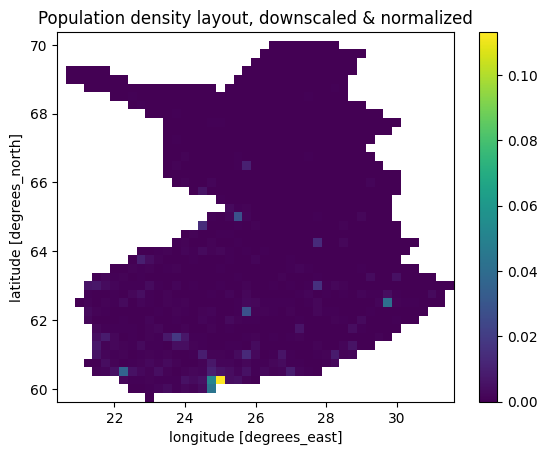

In [7]:
import matplotlib.pyplot as plt

# Reproject Finland GeoDataFrame to EPSG:3035 to match the population density raster
finland_3035 = finland.to_crs("EPSG:3035")

# Clip the raster data and reproject the result back into EPSG:4326 to match the cutout,
# also remove some unnecessary dimensions via `squeeze()`
layout = (
    population_density.rio.clip(
        finland_3035.geometry, from_disk=True
    )  # Clip the population density raster data with the reprojected Finland shape.
    .rio.reproject(  # Reproject and resample the population density raster to match the cutout.
        cutout.crs,
        shape=cutout.shape,
        transform=cutout.transform,
        resampling=5,
        from_disk=True,
    )
    .squeeze()  # Squeeze to remove any unnecessary dimensions.
)

# Normalize the population density layout
layout = layout / layout.sum()

# Plot to inspect the new raster
layout.plot()
plt.title("Population density layout, downscaled & normalized")

For comparison, we'll also create a uniformly distributed layout,
as well as fetch the temperature for the city of *Jyväskylä*. 
The heating degree days of Jyväskylä are used by Statistics Finland for
estimating the heating demand of the Finnish residential building stock,
so it acts as a good comparison for our weather data processing.

In [8]:
import pandas as pd

# Create an uniform layout
uniform = layout.round() + 1.0
uniform = uniform / uniform.sum()

# Create a layout for the city of Jyväskylä.
jyvaskyla = cutout.layout_from_capacity_list(
    pd.DataFrame(data={"x": [25.68], "y": [62.40], "Capacity": 1.0})
)

## Calculating the average weather

Now that we have our layouts ready, we can simply pass them to the `cutout`
to get the weather data we need.
First, let's calculate the ambient temperature and solar irradiation on
vertical surfaces facing different cardinal directions for the population density
weighted layout, the uniform layout, and the city of Jyväskylä.

**Note that we use `layout.fillna(0.)` to fill the missing values with zeroes,**
**as the layouts don't work properly otherwise!**
This was avoided prior to this, as examining the raster data is much easier
when the shape of Finland is clearly visible in the plots,
which is not the case after the `NaN` values are replaced with zeroes.

In [9]:
# Calculate temperature data into a dictionary
temperature_dict = {}
layouts = {"Weighted": layout, "Uniform": uniform, "Jyväskylä": jyvaskyla}
for name, lout in layouts.items():
    temperature_dict[name] = (
        cutout.temperature(layout=lout.fillna(0.0)).squeeze().to_series()
    )

# Calculate radiation data into dictionaries
irr_total = {}
irr_direct = {}
irr_diffuse = {}
dirs = {"north": 0.0, "east": 90.0, "south": 180.0, "west": 270.0}
for name, lout in layouts.items():
    irr_total[name] = {
        d: cutout.irradiation(
            orientation={"slope": 90.0, "azimuth": az}, layout=lout.fillna(0.0)
        )
        .squeeze()
        .to_series()
        for d, az in dirs.items()
    }
    irr_direct[name] = {
        d: cutout.irradiation(
            orientation={"slope": 90.0, "azimuth": az},
            layout=lout.fillna(0.0),
            irradiation="direct",
        )
        .squeeze()
        .to_series()
        for d, az in dirs.items()
    }
    irr_diffuse[name] = {
        d: cutout.irradiation(
            orientation={"slope": 90.0, "azimuth": az},
            layout=lout.fillna(0.0),
            irradiation="diffuse",
        )
        .squeeze()
        .to_series()
        for d, az in dirs.items()
    }

INFO:atlite.convert:Convert and aggregate 'temperature'.
INFO:atlite.convert:Convert and aggregate 'temperature'.
INFO:atlite.convert:Convert and aggregate 'temperature'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and aggregate 'irradiation'.
INFO:atlite.convert:Convert and

## Examine the results via plotting.

Let's start with the ambient temperatures, as the plots are simpler.
In the code below, you can use the `fsize` and `time_to_plot` values to
tweak the size and timeframe of the plots.
These settings are used for all the temperature and irradiation plots
under this section.

We recommend plotting results monthly, e.g. `time_to_plot="2011-06"`,
as it works nicely both for temperature and irradiation data.
However, plotting the full year using `time_to_plot="2011"` can help examine
the big picture for temperature and irradiation,
while daily resolution e.g. `time_to_plot="2011-06-01"` can help examine
the solar irradiation details for the different facing walls.

Note that for yearly plots, you have to change the cutout and re-download
data for the entire year.
Also note that the data uses UTC+0, while Finland generally uses UTC+2.

<Axes: title={'center': 'Ambient temperature comparison'}, xlabel='Datetime', ylabel='Ambient temperature [C]'>

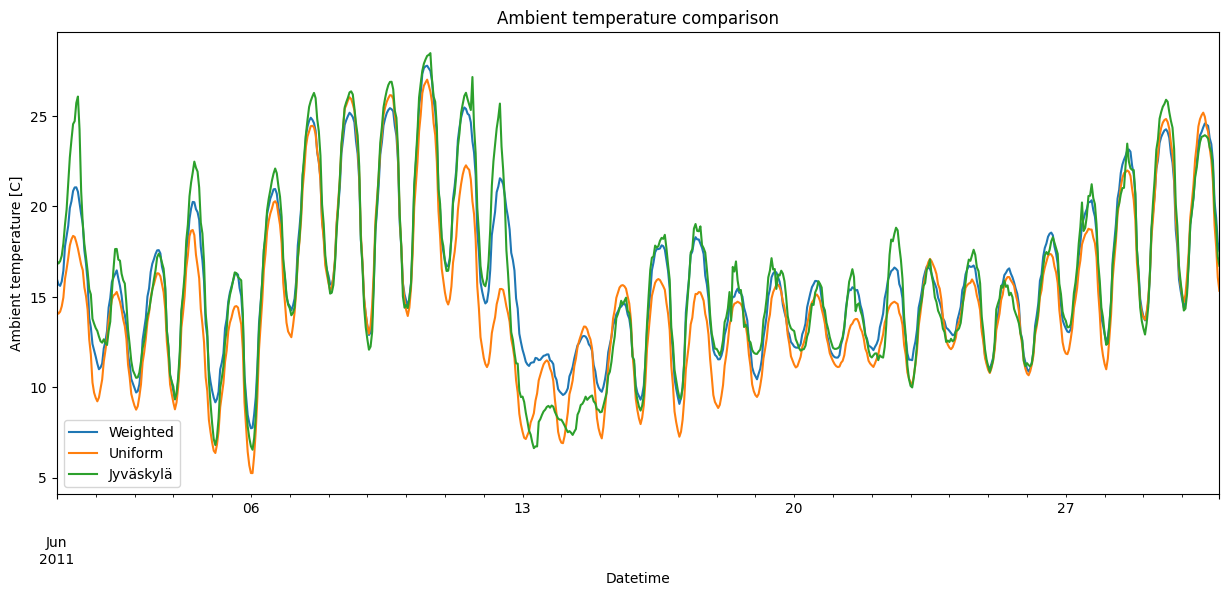

In [10]:
# Define figure size and timeframe for plotting
fsize = (15, 6)
time_to_plot = "2011-06"

# Convert temperature dictionary to dataframe for easier plotting.
temps = pd.DataFrame(temperature_dict)
temps.loc[time_to_plot].plot(
    figsize=fsize,
    title="Ambient temperature comparison",
    ylabel="Ambient temperature [C]",
    xlabel="Datetime",
)

Seems ok. The *Weighted* temperature is more similar to the *Jyväskylä*
temperature than the *Uniform* one, so there's clearly a good reason behind
using the heating degree days from Jyväskylä.
Though, as expected, the *Jyväskylä* temperature is noticeably more volatile
than the averaged temperatures *Weighted* and *Uniform*.

Let's look at the irradiation data next.
First, let's simply examine the total irradiation on the South-facing wall
for the different layouts.

<Axes: title={'center': 'Total irradiation on the south-facing wall'}, xlabel='Datetime', ylabel='Total irradiation [W/m2]'>

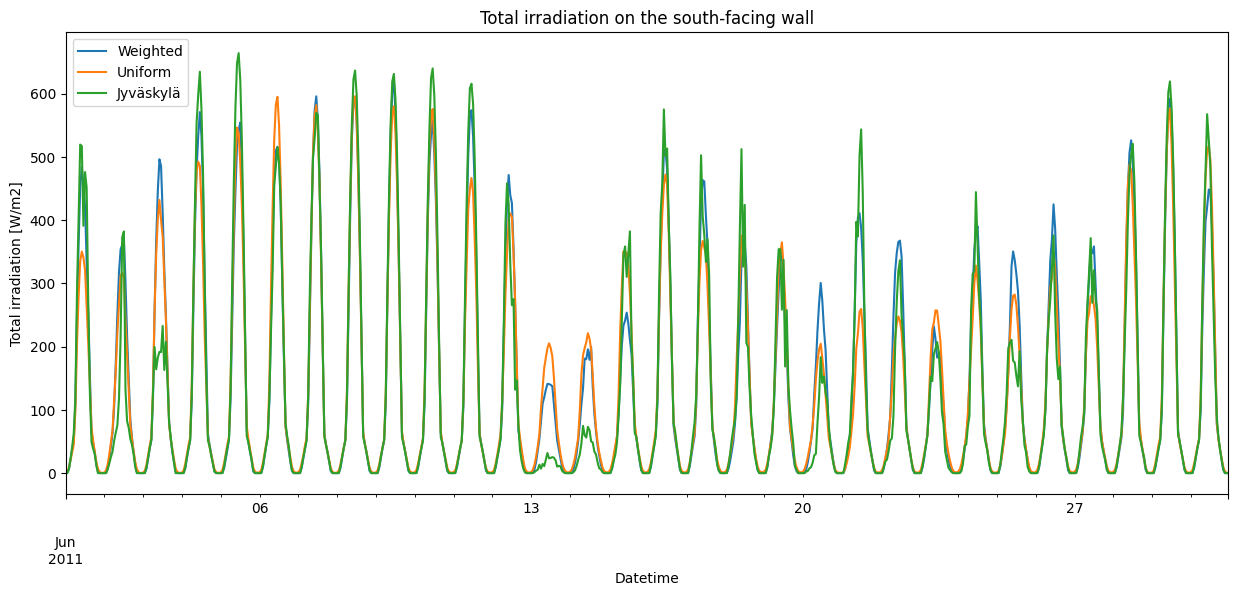

In [11]:
irrads = pd.DataFrame({name: data["south"] for name, data in irr_total.items()})
irrads.loc[time_to_plot].plot(
    figsize=fsize,
    title="Total irradiation on the south-facing wall",
    xlabel="Datetime",
    ylabel="Total irradiation [W/m2]",
)

Unfortunately, here we can no longer see any meaningful correlation between
the different layouts.
Still, we can examine that the total, direct, and diffuse irradiation all
behave as they should for the *Weighted* layout.

<Axes: title={'center': 'Weighted total irradiation on the walls'}, xlabel='Datetime', ylabel='Weighted total irradiation [W/m2]'>

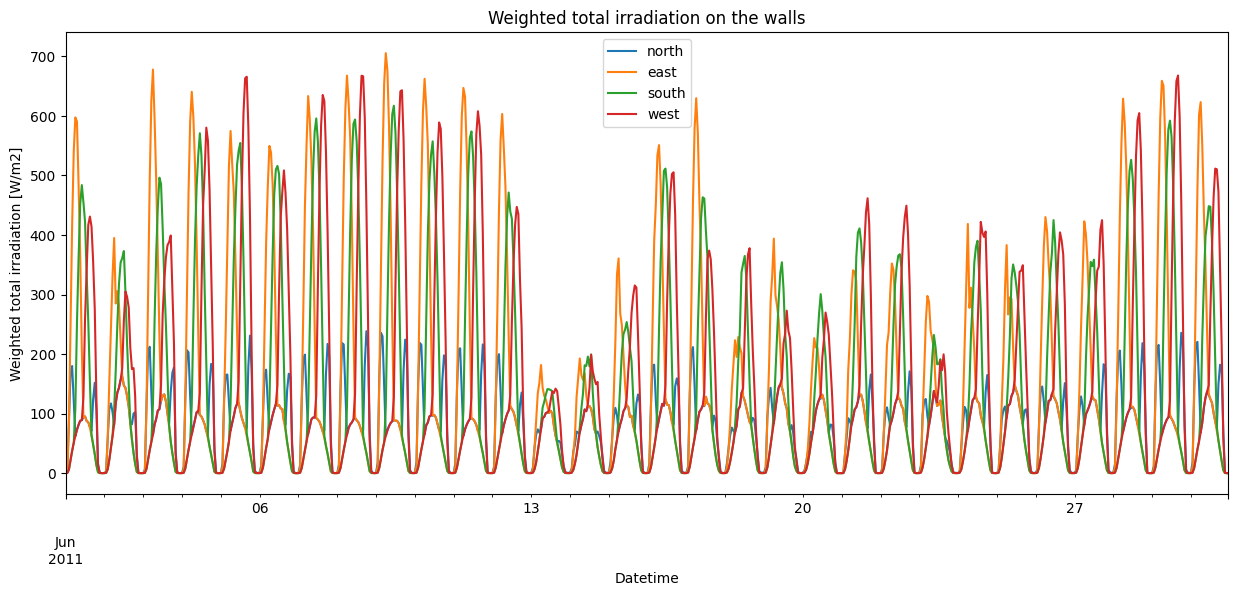

In [12]:
tot_irrads = pd.DataFrame(irr_total["Weighted"])
tot_irrads.loc[time_to_plot].plot(
    figsize=fsize,
    title="Weighted total irradiation on the walls",
    xlabel="Datetime",
    ylabel="Weighted total irradiation [W/m2]",
)

<Axes: title={'center': 'Weighted direct irradiation on the walls'}, xlabel='Datetime', ylabel='Weighted direct irradiation [W/m2]'>

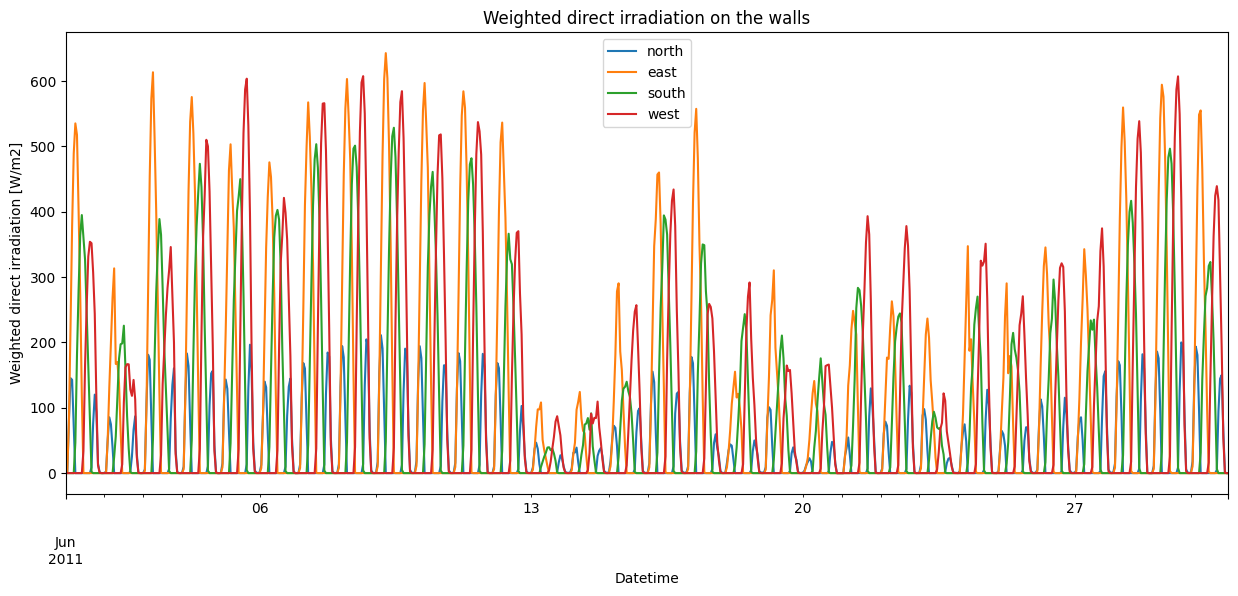

In [13]:
dir_irrads = pd.DataFrame(irr_direct["Weighted"])
dir_irrads.loc[time_to_plot].plot(
    figsize=fsize,
    title="Weighted direct irradiation on the walls",
    xlabel="Datetime",
    ylabel="Weighted direct irradiation [W/m2]",
)

<Axes: title={'center': 'Weighted diffuse irradiation on the walls'}, xlabel='Datetime', ylabel='Weighted diffuse irradiation [W/m2]'>

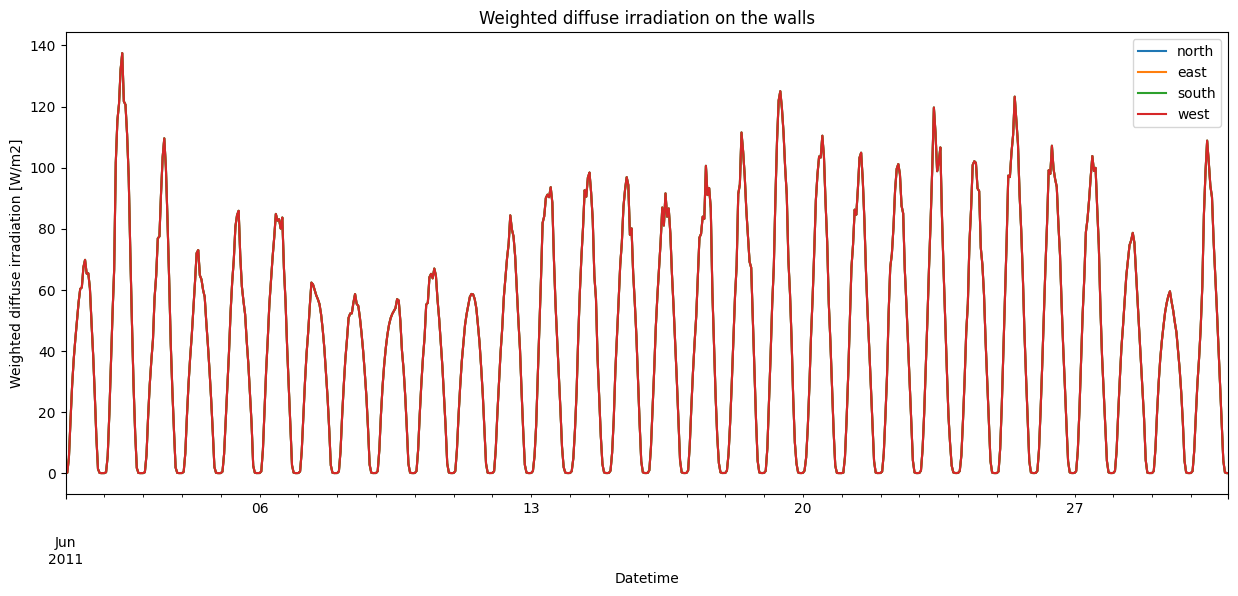

In [14]:
dif_irrads = pd.DataFrame(irr_diffuse["Weighted"])
dif_irrads.loc[time_to_plot].plot(
    figsize=fsize,
    title="Weighted diffuse irradiation on the walls",
    xlabel="Datetime",
    ylabel="Weighted diffuse irradiation [W/m2]",
)

Overall, the irradiation seems to behave as expected.
Direct irradiation peaks at different times for the different walls:
in the morning for the east-facing wall, around noon for the south-facing wall,
in the evening for the west-facing wall, and in both the early morning and
late evening for the north-facing wall in Summer.
Furthermore, the south-facing wall receives lower peak irradiation than the east and west-facing walls in Summer,
as the sun is much higher in the sky during the day compared to the morning and the evening.

Meanwhile, there is no difference in the diffuse irradiation,
as it doesn't matter how the wall is oriented.